This script is for calculating the specific surface area ($S_{BET}$) of a solid sample, including error from Inverse Gas Chromatography measurements, specifically those done on the SEA (Surface energy analyser). Measured parameters are imported from a csv file and the specific surface area of the sample is printed at the end of the document along with visualisations of the adsorption isotherm and BET plot.

In [333]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
from scipy import stats, constants
import matplotlib.pyplot as plt
%matplotlib inline

# Organising data

In [334]:
# Reads csv input file and skips rows to where data start
input_file = raw_input('Copy path to input file here \nmake sure to insert extra "\\" and remove "" \n')
df = pd.read_csv(input_file, skiprows = 17,encoding= 'utf-16',delimiter='\t')

Copy path to input file here 
make sure to insert extra "\" and remove "" 
C:\\Users\\tcd\\Google Drive\\Graphene size study feb 2015\\IGC_raw_data\\Surface_area\\3500-5000rpm_run2.csv


In [335]:
# Removing of solvents that arent used in calculation
df= df[(df.Solvent != 'n/a') & (df.Solvent != 'Methane')]

In [336]:
# Renaming columns with funny character
#df.rename(columns ={"Peak Max (Signal) [u'\xb5'V]": 'peak_max_signal'},inplace=True)
df.rename(columns={df.columns[10] :'peak_area',df.columns[11]: 'peak_max_signal'},inplace=True)

# Removing unwanted rows
df = df[df.peak_area != 0]

#  James-Martin pressure correction, j

$$j=\frac{3}{2}\frac{(\frac{p_{in}}{p_{out}})^{2}-1}{(\frac{p_{in}}{p_{out}})^{3}-1}$$

In [337]:
# Atmospheric pressure in torr
p_out = 760

# input pressure is pressure drop + atomospheric pressure
p_in = df['Column Pressure Drop [Torr]'] + p_out

j = (1.5*(((p_in/p_out)**2 -1)/((p_in/p_out)**3 -1)))

# Net Retention Volume, Vn ($\frac{mL}{g}$)

$$V_{N}=\frac{j}{m}F(t_{r}-t_{0})(\frac{T}{273.15})$$

In [338]:
# Creating input for sample mass and change its units
m_df = pd.read_csv(input_file,nrows=1,header=None,skiprows=4,encoding='utf-16',delimiter='\t')
m=float(m_df.ix[:,1:1].values.flatten())
m = m / 1000 # mg to g
vn = (j * df['Exit Flow Rate [sccm]'] * df['Net Ret Time (Com) [min]'] * df['Column Temperature [Kelvin]'] ) / (m * 273.15)

# Partial pressure, p (Pa)

$$p=\frac{n_{i}RH_{peak}273.15}{FA_{peak}}$$

In [339]:
A_peak = df['peak_area']
n_i = df['Amount  [mMol]']
H_peak = df['peak_max_signal']
F = df['Exit Flow Rate [sccm]']

In [340]:
# Converting units to SI

vn_SI = vn * 0.001 # converts mg/L to m^3/kg
A_peak = A_peak * 6E-5 #converts uV.min to V.sec
n_i = n_i / 1000 # converts mMol to Mol
H_peak = H_peak * 1E-6 # converts uV to V
F = F * 1.6667E-8 #from sscm to m^3/s

In [341]:
# Gas constant
R = constants.R

In [342]:
p = (n_i * R * 273.15 * H_peak) / (F * A_peak) # Pa

#  Amount of probe adsorbed on sample surface, n, ($\frac{mMol}{g}$)

$$n=\frac{1}{RT}\intop_{0}^{p}V_{n}dp$$

In [343]:
# Reindexing series to start at zero
p_reindex = p.reset_index(drop=True)
vn_SI_reindex = vn_SI.reset_index(drop=True)

In [344]:
# T value used in n calc
T_av = df['Column Temperature [Kelvin]'].mean()

In [345]:
# set n as empty array in shape of as other values 
n = np.empty_like(p_reindex)

In [346]:
# Cumulative integration  of vn with respect to partial pressure p
n[0] = (p_reindex[0] * vn_SI_reindex[0]) / (R * T_av)
for i in range(1, len(p_reindex)):
    n[i] = (p_reindex[i] - p_reindex[i - 1]) * (vn_SI_reindex[i] / (R * T_av)) + n[i - 1]

In [347]:
# set n as series with same index as p_reindex and vn_SI_reindex
n = Series(n)

# Saturation vapour pressure calculation, $p_{sat}$ (Pa)

$$\log_{10}p_{sat}=A-\frac{B}{C+T}$$
$$p_{sat}=10^{(A-\frac{B}{C+T})}$$

In [348]:
# Antoine coefficients for octane (probe used for surface area calculations from AntoineConstants excel file)

In [349]:
# Coefficents A,B,C are for T = 20C
A = 6.91868
B = 1351.99
C = 209.155


p_sat = 10 ** (A- (B /(20+C))) # mmHg T= 20C
p_sat = p_sat * 133.322 # mmHg to Pa

# Relative pressure, $p_{rel}$

$$p_{rel}=\frac{p}{p_{sat}}$$

In [350]:
p_rel = p_reindex / p_sat

# Adsorption Isotherm Plot

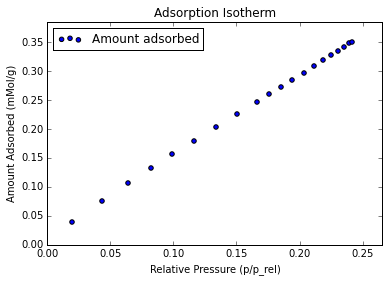

In [351]:
plt.scatter(p_rel, n,label='Amount adsorbed')
plt.title('Adsorption Isotherm')
plt.xlabel('Relative Pressure (p/p_rel)')
plt.ylabel('Amount Adsorbed (mMol/g)')
x_max = max(p_rel) + (0.1 * max(p_rel))
y_max = max(n) + (0.1 * max(n))
plt.ylim(0,y_max)
plt.xlim(0,x_max)
plt.legend(loc='upper left')

#  BET  equation plot and calculation

$$\frac{p}{n(p-p_{sat})}=\frac{C-1}{n_{m}C}\frac{p}{p_{sat}}+\frac{1}{n_{m}C}$$

In [352]:
# setting Y axis for BET plot
y_BET = p_reindex / (n * (p_sat - p_reindex))

In [353]:
# set up BET dataframe
BET_df = pd.concat([p_rel, y_BET], axis = 1)
BET_df.columns = ['p_rel', 'y_BET']

In [354]:
# BET equation is only valid between p_rel values of 0.05 to 0.35
BET_df = BET_df[(BET_df.p_rel >= 0.05) & (BET_df.p_rel <= 0.35)]

In [355]:
BET_df['sq_resid'] = np.nan
BET_df

,p_rel,y_BET,sq_resid
2,0.063915,0.638716,NaN
3,0.082120,0.674505,NaN
4,0.099318,0.704535,NaN
5,0.116196,0.732060,NaN
6,0.133491,0.758198,NaN
7,0.150684,0.784706,NaN
8,0.165950,0.806626,NaN
9,0.175950,0.820569,NaN
10,0.185123,0.833196,NaN
11,0.194311,0.845881,NaN


In [356]:
# Function does linear regression and if threshold r_sq values isnt reached it removes point with largest square residual
# and repeats the linear regression without that point until r_sq value is reached

def regress(df):
    # Linear regression of BET plot within allowed p_rel range
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['p_rel'],df['y_BET'])
    
    r_sq = r_value ** 2
    
    
    if r_sq < 0.995:
        
        df['sq_resid'] = (df['y_BET'] - ((df['p_rel'] * slope) + intercept)) ** 2
        
        return regress(df.drop(df['sq_resid'].idxmax()))
    
    else:
        
        sse = ((df['y_BET'] - ((slope * df['p_rel']) + intercept)) ** 2).sum()
        n = len(df['p_rel'])
        var = np.sqrt((sse / (n - 2)))
        x_mean = df['p_rel'].mean()
        sx2 = ((df['p_rel'] - x_mean) **2).sum()
        intercept_err = var * np.sqrt((1/n) + (x_mean ** 2) / sx2)
        print df
        
        return slope,intercept,r_value,p_value,std_err,r_sq, intercept_err
        
        
  

In [357]:
slope,intercept,r_value,p_value,std_err,r_sq, intercept_err = regress(BET_df)

       p_rel     y_BET  sq_resid
2   0.063915  0.638716       NaN
3   0.082120  0.674505       NaN
4   0.099318  0.704535       NaN
5   0.116196  0.732060       NaN
6   0.133491  0.758198       NaN
7   0.150684  0.784706       NaN
8   0.165950  0.806626       NaN
9   0.175950  0.820569       NaN
10  0.185123  0.833196       NaN
11  0.194311  0.845881       NaN
12  0.203377  0.858218       NaN
13  0.211143  0.868529       NaN
14  0.218606  0.878545       NaN
15  0.225264  0.887405       NaN
16  0.230727  0.894579       NaN
17  0.235539  0.900774       NaN
18  0.239596  0.905931       NaN
19  0.241271  0.908054       NaN


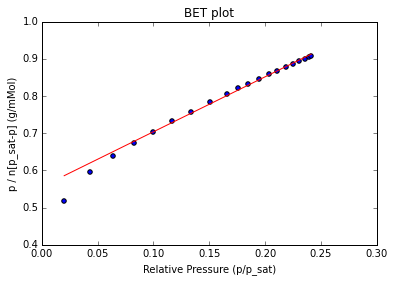

In [358]:
# BET plot
plt.scatter(p_rel,y_BET)
plt.plot(p_rel, (p_rel * slope) + intercept, c='r')
plt.title('BET plot')
plt.xlabel('Relative Pressure (p/p_sat)')
plt.ylabel('p / n[p_sat-p] (g/mMol)')


$$n_{m}=\frac{1}{slope+intercept}$$

In [359]:
# The monolayer capacity, n_m is found from slope and intercept of fitted line from BET plot

n_m = 1 / (slope + intercept) # mMol/g
err_slope_intercept = np.sqrt((std_err) ** 2 + (intercept_err) ** 2) # error in slope+intercept
n_m_err = n_m * (err_slope_intercept / (slope + intercept)) # error in n_m
n_m = n_m / 1000 # change units from mMol/g to Mol/g
n_m_err = n_m_err / 1000 # change units from mMol/g to Mol/g

#  Specific Surface Area, $\frac{m^{2}}{g}$

$$S_{BET}=n_{m}N_{a}a$$

In [360]:
a = 6.3E-19 # m^2 This is the cross-sectional surface area of a Octane molecule
Na = constants.Avogadro

In [361]:
ssa = n_m * Na * a
ssa_err = ssa * (n_m_err / n_m)

In [362]:
print 'The SSA is %.2f with error %.2f and R^2 of %.4f' % (ssa,ssa_err,r_sq)

The SSA is 186.61 with error 1.88 and R^2 of 0.9970
